In [1]:
!pip install -U tqdm torchsummary catboost xgboost lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0
  Attempting uninstall: catboost
    Found existing installation: catboost 1.2.3
    Uninstalling catboost-1.2.3:
      Successfully uninstalled catboost-1.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is

# Importing libraries - Импорт библиотек


In [2]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import cv2
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize

from tqdm import tqdm_notebook
import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

In [3]:
def result_pred(pred, pred_prob, resY, classes):
    print(f'roc_auc_score: {roc_auc_score(label_binarize(resY, classes=classes), pred_prob, multi_class="ovr")}',
     f'accuracy:{accuracy_score(resY, pred)}',
     f"f1_score:{f1_score(resY, pred, average='weighted')}")


def result_value(pred, pred_prob, resY, classes):
    return [
        roc_auc_score(label_binarize(resY, classes=classes), pred_prob, multi_class="ovr"), 
        accuracy_score(resY, pred),
        f1_score(resY, pred, average='weighted')
    ]


def result_table(models, resY, X, classes, subcol=None, valueSubCol=None):
    if subcol and valueSubCol:
        dt = {subcol: valueSubCol,
            'roc_auc_score': [],
             'accuracy': [],
             'f1_score': []}
    else:
        dt = {'roc_auc_score': [],
             'accuracy': [],
             'f1_score': []}
    for model in models:
        pred = model.predict(X)
        tmp = result_value(model.predict(X), model.predict_proba(X), resY, classes)
        dt['roc_auc_score'].append(tmp[0])
        dt['accuracy'].append(tmp[1])
        dt['f1_score'].append(tmp[-1])
    return dt

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Data analysis - Анализ данных

In [5]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [6]:
max(data.max())

255

In [7]:
data[data.drop(columns=['label']).columns] = data.drop(columns=['label']) / 255

In [8]:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float64(784), int64(1)
memory usage: 251.5 MB


In [10]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 251.54 MB
Memory usage after optimization is: 62.85 MB
Decreased by 75.0%


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float16(784), int8(1)
memory usage: 62.8 MB


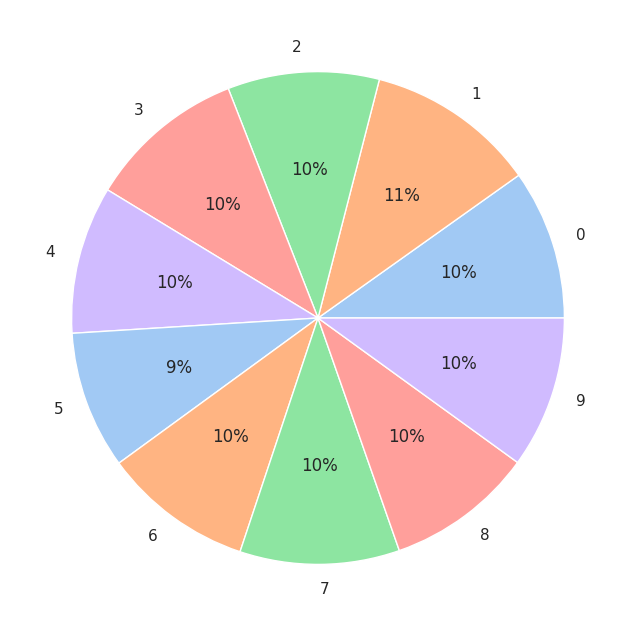

In [12]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['label'].unique())
dt = np.array([len(data[data['label'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

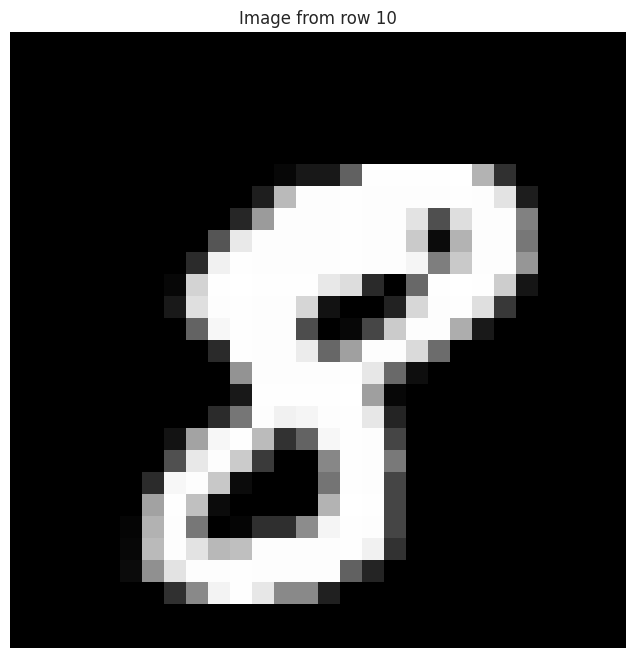

In [13]:
index = 10
image_data = data.iloc[index, 1:].values
image_shape = (28, 28)

# Reshape the 1D array to a 2D array representing the image
image_array = image_data.reshape(image_shape)

# Plot the image
plt.imshow(image_array, cmap='gray')
plt.axis('off')
plt.title(f"Image from row {index}")
plt.show();

In [14]:
image_array.shape

(28, 28)

# ML

## Divide into test and validation samples - Разделим на тестовые и валидационные выборки

In [15]:
X = data.drop(columns=['label'])
Y = data['label']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

In [16]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((37800, 784), (4200, 784), (37800,), (4200,))

## fit models

In [17]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    eval_metric='TotalF1',
    use_best_model=True,
    learning_rate=0.04,
    random_seed=42,
    l2_leaf_reg=8,
    grow_policy='Depthwise',
    depth=8,
    od_type='Iter',
    od_wait=512,
    rsm=1,
    fold_permutation_block=550,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=64,
    task_type='GPU'
)


cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.8329880	test: 0.8019752	best: 0.8019752 (0)	total: 18.9s	remaining: 1d 18h 55m 15s
512:	learn: 0.9998413	test: 0.9702421	best: 0.9707188 (507)	total: 1m 24s	remaining: 21m 5s
1024:	learn: 1.0000000	test: 0.9742855	best: 0.9745254 (997)	total: 2m 21s	remaining: 16m 27s
1536:	learn: 1.0000000	test: 0.9759600	best: 0.9759637 (1415)	total: 3m 14s	remaining: 14m
2048:	learn: 1.0000000	test: 0.9764394	best: 0.9766762 (1843)	total: 4m 3s	remaining: 12m 11s
2560:	learn: 1.0000000	test: 0.9773877	best: 0.9773877 (2367)	total: 4m 52s	remaining: 10m 44s
3072:	learn: 1.0000000	test: 0.9773887	best: 0.9776254 (2766)	total: 5m 41s	remaining: 9m 28s
3584:	learn: 1.0000000	test: 0.9778636	best: 0.9778636 (3296)	total: 6m 28s	remaining: 8m 19s
4096:	learn: 1.0000000	test: 0.9781004	best: 0.9783368 (3709)	total: 7m 15s	remaining: 7m 15s
bestTest = 0.9783368254
bestIteration = 3709
Shrink model to first 3710 iterations.


In [18]:
result_pred(cat.predict(X_valid), cat.predict_proba(X_valid), Y_valid, cat.classes_)

roc_auc_score: 0.9995444943153455 accuracy:0.9783333333333334 f1_score:0.9783368254361344


In [19]:
lgbm = LGBMClassifier(
    boosting_type='dart',
    learning_rate=0.6,
    n_estimators=1024,
    reg_alpha=0.6,
    reg_lambda=0.6,
    random_state=42,
    device='gpu',
    importance_type='gain',
    min_child_weight=4e-3,
    min_child_samples=128,
    verbose=-1
)

lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LGBMClassifier(boosting_type='dart', device='gpu', importance_type='gain',
               learning_rate=0.6, min_child_samples=128, min_child_weight=0.004,
               n_estimators=1024, random_state=42, reg_alpha=0.6,
               reg_lambda=0.6, verbose=-1)

In [20]:
result_pred(lgbm.predict(X_valid), lgbm.predict_proba(X_valid), Y_valid, cat.classes_)

roc_auc_score: 0.9995283630537756 accuracy:0.9778571428571429 f1_score:0.977851832287845


In [21]:
xgb = XGBClassifier(
    booster='dart',
    n_estimators=1024,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.5,
    gamma=0.08,
    random_state=42,
    device="cuda"
)

xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=64, verbose=128)

[0]	validation_0-mlogloss:2.19177
[128]	validation_0-mlogloss:0.20495
[256]	validation_0-mlogloss:0.11091
[384]	validation_0-mlogloss:0.09107
[512]	validation_0-mlogloss:0.08451
[640]	validation_0-mlogloss:0.08249
[768]	validation_0-mlogloss:0.08225
[896]	validation_0-mlogloss:0.08208
[1023]	validation_0-mlogloss:0.08199


XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.08, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1024, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
result_pred(xgb.predict(X_valid), lgbm.predict_proba(X_valid), Y_valid, cat.classes_)

roc_auc_score: 0.9995283630537756 accuracy:0.9764285714285714 f1_score:0.9764345941198127


In [23]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [24]:
test = test / 255
test = reduce_mem_usage(test)

Memory usage of dataframe is 167.48 MB
Memory usage after optimization is: 41.87 MB
Decreased by 75.0%


In [25]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [27]:
sub

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [28]:
sub['Label'] = cat.predict(test)
sub.to_csv('cat.csv', index=False) # 0.97514 on Public

In [29]:
sub['Label'] = lgbm.predict(test)
sub.to_csv('lgbm.csv', index=False) # 0.97303 on Public

In [30]:
sub['Label'] = xgb.predict(test)
sub.to_csv('xgb.csv', index=False) # 0.97207 on Public

In [31]:
sub['Label'] = np.argmax(cat.predict_proba(test) * 0.5 + lgbm.predict_proba(test) * 0.3 + xgb.predict_proba(test) * 0.2, axis=-1)

In [32]:
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [33]:
sub.to_csv('blending.csv', index=False) # 0.97453 on Public

# DL

## Let's take a ready-made dataset from PyTorch, and then additionally train it on this one from Kaggle - Возьмем готовый датасет из PyTorch, а потом дообучим на данном из Kaggle

In [34]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=8)

classes = tuple(str(i) for i in range(10))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17163286.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468365.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4400393.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2293586.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [35]:
trainloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [36]:
testloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

In [37]:
trainloader.dataset.train_data[1].size()

torch.Size([28, 28])

torch.Size([28, 28])


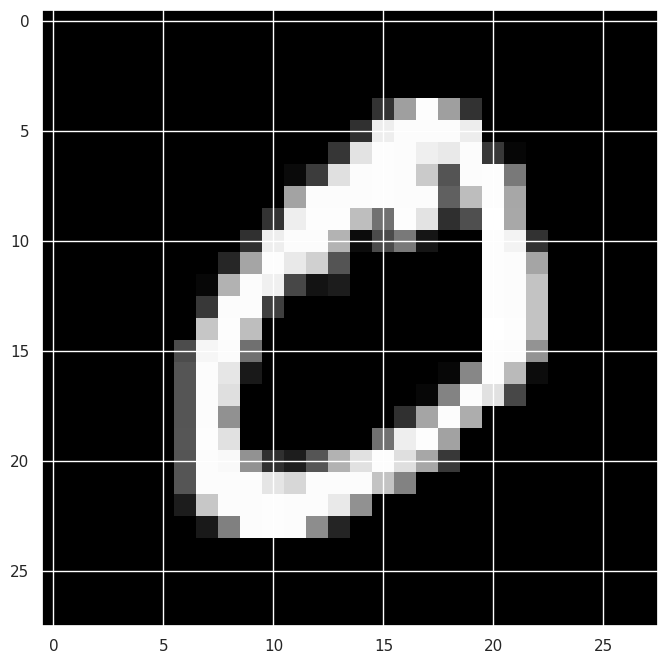

In [38]:
numpy_img = trainloader.dataset.train_data[1].numpy()
print(trainloader.dataset.train_data[1].size())
plt.imshow(numpy_img, cmap='gray');

In [39]:
trainloader.dataset.train_data[1].numpy().dtype

dtype('uint8')

In [40]:
# trainloader.dataset.train_data[0].numpy().max()

In [41]:
# block_convolution = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten()
#         ).cuda()

In [42]:
# trainloader.dataset.train_data[:32].size()

In [43]:
for batch_index, batch in enumerate(tqdm.notebook.tqdm(trainloader)):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    break

  0%|          | 0/1875 [00:00<?, ?it/s]

In [44]:
x_batch.size()

torch.Size([32, 1, 28, 28])

In [45]:
x_batch.dtype

torch.float32

In [46]:
x_batch[0].size()

torch.Size([1, 28, 28])

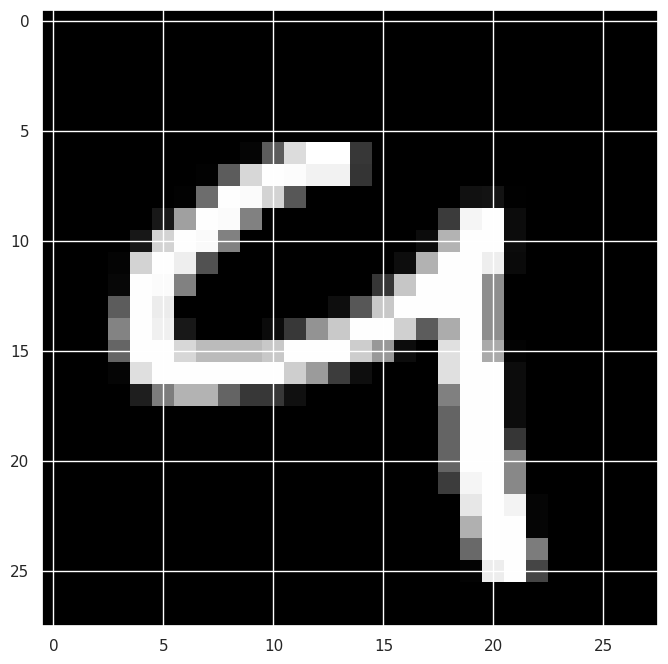

In [47]:
plt.imshow(x_batch[0][0].cpu(), cmap='gray');

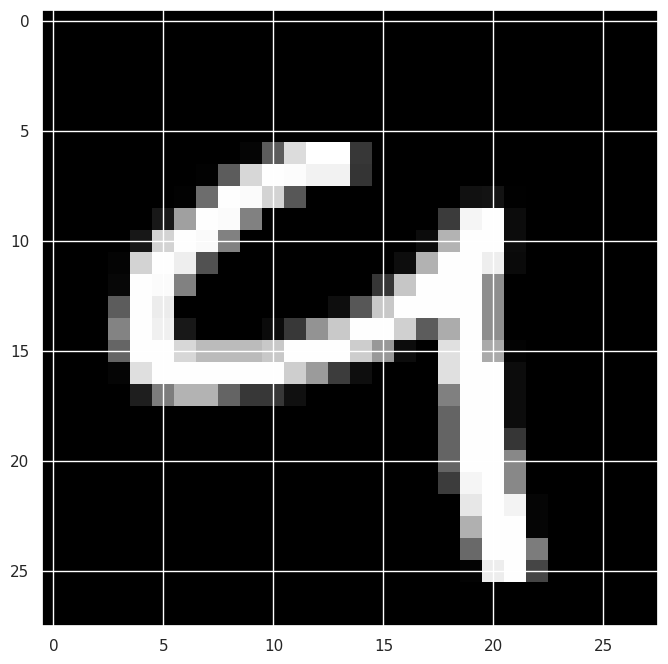

In [48]:
plt.imshow(x_batch[0].cpu().squeeze(), cmap='gray');

In [49]:
# x_batch[0][0].amax()

In [50]:
# x = block_convolution(x_batch)

In [51]:
# x.size()

In [52]:
# 64 * 4 * 3 * 2

In [53]:
# 3872 / 

In [54]:
# x.view(x.size(0), -1).size()

In [55]:
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        
        self.block_convolution = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        
        self.block_cnn = nn.Sequential(
            nn.Linear(3872, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 10)
        )
        
        for m in self.block_convolution.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                
        for m in self.block_cnn.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.block_convolution(x)
        x = self.block_cnn(x)
        return x

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

class Metrics:
    @staticmethod
    def f1_score_multiclass(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    @staticmethod
    def precision_multiclass(y_true, y_pred):
        return precision_score(y_true, y_pred, average='weighted')

    @staticmethod
    def recall_multiclass(y_true, y_pred):
        return recall_score(y_true, y_pred, average='weighted')

    @staticmethod
    def accuracy_multiclass(y_true, y_pred):
        return accuracy_score(y_true, y_pred)


In [57]:
model = MNIST_Classifier().to(device)
model

MNIST_Classifier(
  (block_convolution): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (block_cnn): Sequential(
    (0): Linear(in_features=3872, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps

In [58]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             544
              ReLU-2           [-1, 32, 25, 25]               0
            Conv2d-3           [-1, 64, 23, 23]          18,496
              ReLU-4           [-1, 64, 23, 23]               0
            Conv2d-5           [-1, 32, 22, 22]           8,224
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
           Flatten-8                 [-1, 3872]               0
            Linear-9                  [-1, 512]       1,982,976
      BatchNorm1d-10                  [-1, 512]           1,024
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                  [-1, 256]         131,328
      BatchNorm1d-14                  [

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

metrics_functions = Metrics

In [60]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function
    model.train(True)
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for batch_index, batch in enumerate(tqdm.notebook.tqdm(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output.squeeze(), y_batch)
        
        batch_size = x_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_argmax = torch.argmax(output, axis=1)
        metric_res['f1_score'] += metric_f.f1_score_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
        metric_res['precision'] += metric_f.precision_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
        metric_res['recall'] += metric_f.recall_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
        metric_res['accuracy'] += metric_f.accuracy_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res

In [61]:
def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    for batch_index, batch in enumerate(tqdm.notebook.tqdm(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].type(torch.LongTensor).to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output.squeeze(), y_batch)
            
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            output_argmax = torch.argmax(output, axis=1)
            metric_res['f1_score'] += metric_f.f1_score_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['precision'] += metric_f.precision_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['recall'] += metric_f.recall_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
            metric_res['accuracy'] += metric_f.accuracy_multiclass(y_batch.cpu(), output_argmax.cpu()) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res

In [62]:
def predict(data_loader, device, model: torch.nn.Module):
    model.eval()
    all_preds = []
    all_targets = []
    for batch in tqdm.notebook.tqdm(data_loader):
        x_batch = batch[0].to(device)
        with torch.no_grad():
            output = model(x_batch)
            output_argmax = torch.argmax(output, axis=1)
            all_preds.extend(output_argmax.cpu().tolist())

    return all_preds

In [63]:
epoches = 16

train_losses = []
metric_res_train = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

valid_losses = []
metric_res_valid = {
        'f1_score': [],
        'precision': [],
        'recall': [],
        'accuracy': []
    }

for epoch in range(epoches):
    losses, metric_res = train_one_epoch(trainloader, epoch, metrics_functions)
    train_losses.append(losses)
    for i in metric_res:
        metric_res_train[i].append(metric_res[i])
    
    losses, metric_res = validation_one_epoch(testloader, metrics_functions)
    valid_losses.append(losses)
    for i in metric_res:
        metric_res_valid[i].append(metric_res[i])

Epoch train: 1
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.3663852015554905
f1_score: 0.8948861226229328
precision: 0.9195394705294723
recall: 0.8928
accuracy: 0.8928


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.04312942847058293
f1_score: 0.9867866666666667
precision: 0.9892416666666666
recall: 0.9871
accuracy: 0.9871
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.11617778178552786
f1_score: 0.96890047205947
precision: 0.9800933201058226
recall: 0.96625
accuracy: 0.96625


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.04119543544157641
f1_score: 0.9863238095238094
precision: 0.9883
recall: 0.9868
accuracy: 0.9868
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.0877627791321526
f1_score: 0.9775263272644946
precision: 0.9857175066137579
recall: 0.9754
accuracy: 0.9754


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.03115901593859453
f1_score: 0.9895195238095239
precision: 0.9913666666666668
recall: 0.9898
accuracy: 0.9898
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.07046722964799652
f1_score: 0.9808934100936595
precision: 0.9877878439153452
recall: 0.9791166666666666
accuracy: 0.9791166666666666


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.0287698822937793
f1_score: 0.9899204761904761
precision: 0.9919
recall: 0.9901
accuracy: 0.9901
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.061528622503454485
f1_score: 0.9835466539857287
precision: 0.9894479365079374
recall: 0.98205
accuracy: 0.98205


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.026056332641743212
f1_score: 0.9913390476190476
precision: 0.993175
recall: 0.9914
accuracy: 0.9914
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.0529340447718588
f1_score: 0.9858566683134089
precision: 0.990978095238096
recall: 0.9844833333333334
accuracy: 0.9844833333333334


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.025043733041143424
f1_score: 0.9920057142857142
precision: 0.9935
recall: 0.9922
accuracy: 0.9922
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.044419425702498606
f1_score: 0.9880507973666036
precision: 0.9924705886243399
recall: 0.9868333333333333
accuracy: 0.9868333333333333


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.02417912442804809
f1_score: 0.9921128571428569
precision: 0.9930833333333334
recall: 0.9925
accuracy: 0.9925
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.039469932749774304
f1_score: 0.9889995797183826
precision: 0.9930935383597895
recall: 0.9878666666666667
accuracy: 0.9878666666666667


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.027643977252748936
f1_score: 0.9916261904761905
precision: 0.9931416666666666
recall: 0.9918
accuracy: 0.9918
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.035783882540627386
f1_score: 0.9904708089429474
precision: 0.9938668121693133
recall: 0.9896166666666667
accuracy: 0.9896166666666667


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.02128076454040256
f1_score: 0.9929433333333331
precision: 0.994325
recall: 0.9931
accuracy: 0.9931
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.033985573430320555
f1_score: 0.9906734721948723
precision: 0.9940064285714302
recall: 0.9898333333333333
accuracy: 0.9898333333333333


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.023956860263280713
f1_score: 0.99355
precision: 0.9946750000000002
recall: 0.9937
accuracy: 0.9937
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.031119857402611525
f1_score: 0.9914343521897765
precision: 0.9946722023809541
recall: 0.9904666666666667
accuracy: 0.9904666666666667


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.025692729217290888
f1_score: 0.9923833333333332
precision: 0.9938916666666666
recall: 0.9925
accuracy: 0.9925
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.027569412310914292
f1_score: 0.9922983869652003
precision: 0.9950432142857147
recall: 0.9915666666666667
accuracy: 0.9915666666666667


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.02581313239750416
f1_score: 0.9926366666666663
precision: 0.9939166666666668
recall: 0.9928
accuracy: 0.9928
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.024550748683721757
f1_score: 0.9934906602328692
precision: 0.9959791865079373
recall: 0.99275
accuracy: 0.99275


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.021820365716084894
f1_score: 0.993272857142857
precision: 0.9941916666666668
recall: 0.9936
accuracy: 0.9936
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.023703572371508927
f1_score: 0.9933134060428439
precision: 0.9957760119047617
recall: 0.9926333333333334
accuracy: 0.9926333333333334


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.025357977670952322
f1_score: 0.9931938095238092
precision: 0.9942250000000001
recall: 0.9935
accuracy: 0.9935
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.020871911888265943
f1_score: 0.9941544000398163
precision: 0.9963229761904763
recall: 0.99355
accuracy: 0.99355


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.023878704076387543
f1_score: 0.993131904761905
precision: 0.9945833333333334
recall: 0.9932
accuracy: 0.9932
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/1875 [00:00<?, ?it/s]

loss train: 0.022447677728962542
f1_score: 0.9936626759867226
precision: 0.9961514682539689
recall: 0.9928833333333333
accuracy: 0.9928833333333333


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.02106501196014092
f1_score: 0.9943661904761906
precision: 0.99535
recall: 0.9944
accuracy: 0.9944
-----------------------------------



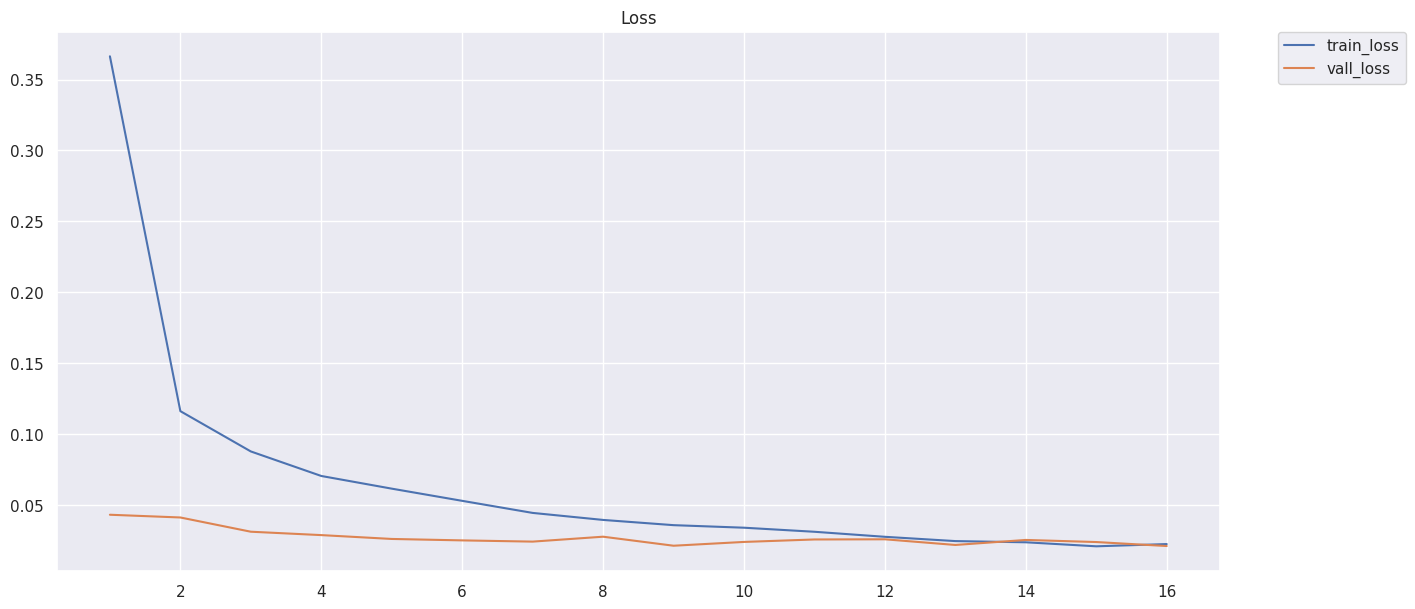

In [64]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

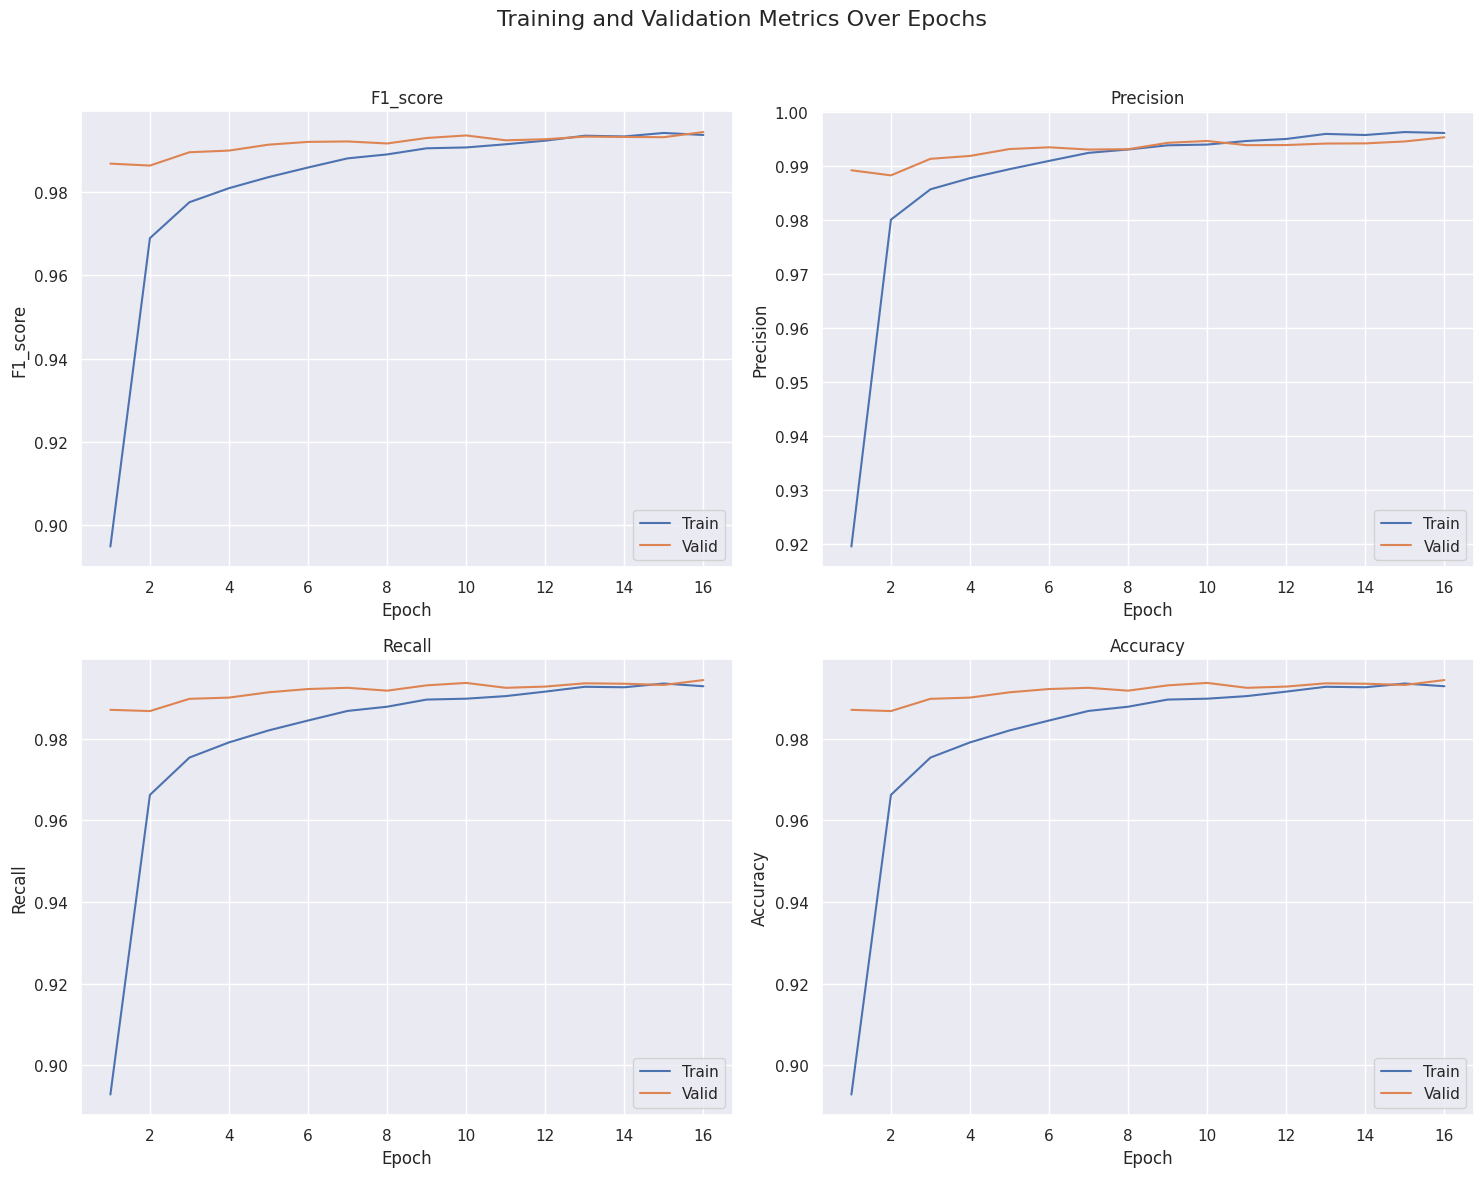

In [65]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [66]:
class MNIST_kaggle_data(Dataset):
    def __init__(self, df, transform=transforms.Compose([transforms.ToTensor()])): 
        if len(df.columns) == 784:
            self.X = df.values.reshape(-1, 28, 28, 1)
            self.y = torch.from_numpy(np.zeros(df.shape[0], dtype=np.int64))
        else:
            self.X = df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
            self.y = torch.from_numpy(df.iloc[:, 0].values).type(torch.int64)
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        if self.transform:
            X_transformed = self.transform(self.X[i]).type(torch.float32)
        else:
            X_transformed = self.X[i].type(torch.float32)
        return X_transformed, self.y[i]

## Let's not retrain, let's see what happens - Не будем дообучать, посмотрим что получится

In [67]:
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: float16(784)
memory usage: 41.9 MB


In [69]:
test_dataset = MNIST_kaggle_data(
    test,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=28,
    shuffle=False
)

In [70]:
for batch in test_dataloader:
    break

In [71]:
batch[0].size()

torch.Size([28, 1, 28, 28])

In [72]:
batch[0][0][0].size()

torch.Size([28, 28])

In [73]:
batch[0][0].dtype

torch.float32

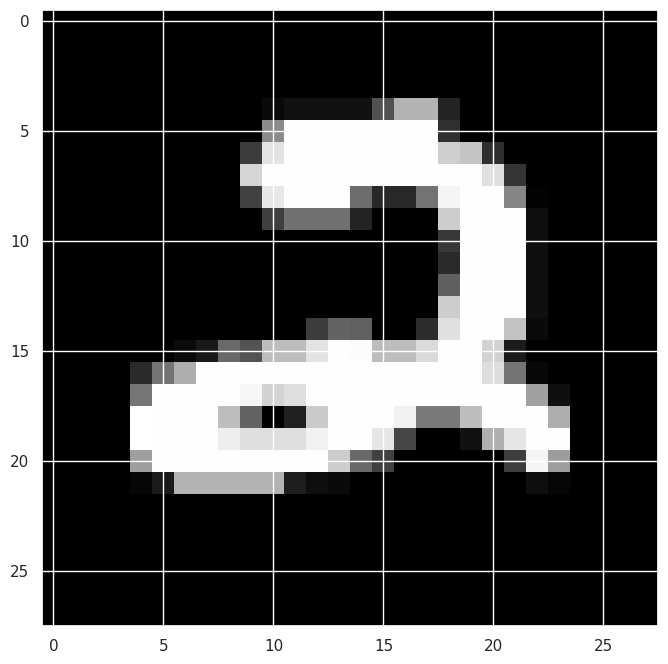

In [74]:
plt.imshow(batch[0][0][0], cmap='gray');

In [75]:
sub['Label'] = predict(test_dataloader, device, model)
sub.to_csv('model_torch_not_Additional_training.csv', index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [76]:
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [77]:
sub['Label'].unique()

array([2, 0, 9, 3, 7, 5, 4, 1, 6, 8])

## We will train and check - Дообучим и проверим

In [78]:
train_dataset_kaggle = MNIST_kaggle_data(
    data,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_loader_kaggle = torch.utils.data.DataLoader(
    dataset=train_dataset_kaggle,
    batch_size=32,
    shuffle=True
)

In [79]:
for i in train_loader_kaggle:
    break

In [80]:
torch.amax(i[0][0])

tensor(1.)

torch.Size([1, 28, 28]) (28, 28)


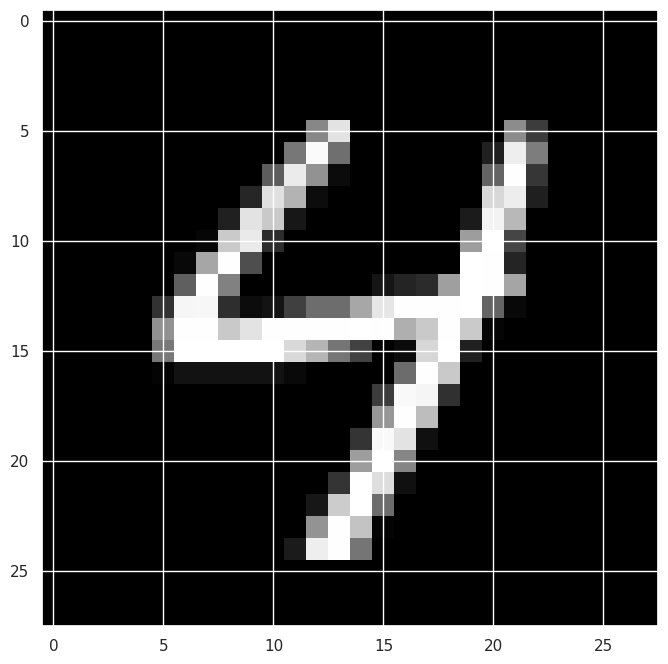

In [81]:
numpy_img = i[0][0].numpy()
print(i[0][0].size(), np.squeeze(numpy_img).shape)
plt.imshow(np.squeeze(numpy_img), cmap='gray');

In [82]:
for epoch in range(8):
    losses, metric_res = train_one_epoch(train_loader_kaggle, epoch, metrics_functions)
    train_losses.append(losses)
    for i in metric_res:
        metric_res_train[i].append(metric_res[i])
    
    losses, metric_res = validation_one_epoch(testloader, metrics_functions)
    valid_losses.append(losses)
    for i in metric_res:
        metric_res_valid[i].append(metric_res[i])

Epoch train: 1
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.021929233497091836
f1_score: 0.994102824871002
precision: 0.9961844104308398
recall: 0.9935238095238095
accuracy: 0.9935238095238095


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.015768259625781957
f1_score: 0.9956828571428572
precision: 0.9965333333333332
recall: 0.9957
accuracy: 0.9957
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.018574559286347634
f1_score: 0.9953903117307524
precision: 0.9971821428571429
recall: 0.9948095238095238
accuracy: 0.9948095238095238


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.016638583196914657
f1_score: 0.9959595238095237
precision: 0.9964666666666666
recall: 0.9961
accuracy: 0.9961
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.01966195922543938
f1_score: 0.9946599480817963
precision: 0.9966933106575967
recall: 0.9940714285714286
accuracy: 0.9940714285714286


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.01184850763921986
f1_score: 0.9968895238095238
precision: 0.9975
recall: 0.9969
accuracy: 0.9969
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.017195110246216203
f1_score: 0.9951392986021135
precision: 0.9970157596371881
recall: 0.994547619047619
accuracy: 0.994547619047619


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.00959103530841753
f1_score: 0.9974666666666668
precision: 0.9979833333333334
recall: 0.9975
accuracy: 0.9975
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.013967143752395973
f1_score: 0.9959774638551282
precision: 0.9975742630385487
recall: 0.995452380952381
accuracy: 0.995452380952381


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.008587322128887047
f1_score: 0.9979666666666668
precision: 0.9983
recall: 0.9981
accuracy: 0.9981
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.017924123274202602
f1_score: 0.9952093889729446
precision: 0.997235544217687
recall: 0.9944761904761905
accuracy: 0.9944761904761905


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.010359418239175357
f1_score: 0.9976533333333331
precision: 0.9981833333333334
recall: 0.9977
accuracy: 0.9977
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.012886243508346351
f1_score: 0.9964046512491219
precision: 0.997924404761905
recall: 0.9958333333333333
accuracy: 0.9958333333333333


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.009199527774551743
f1_score: 0.9985333333333334
precision: 0.9988833333333333
recall: 0.9985
accuracy: 0.9985
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/1313 [00:00<?, ?it/s]

loss train: 0.014394431848045704
f1_score: 0.996096437988355
precision: 0.9976502267573695
recall: 0.9956190476190476
accuracy: 0.9956190476190476


  0%|          | 0/1250 [00:00<?, ?it/s]

Loss validation: 0.009961790757766719
f1_score: 0.9974200000000001
precision: 0.9977
recall: 0.9976
accuracy: 0.9976
-----------------------------------



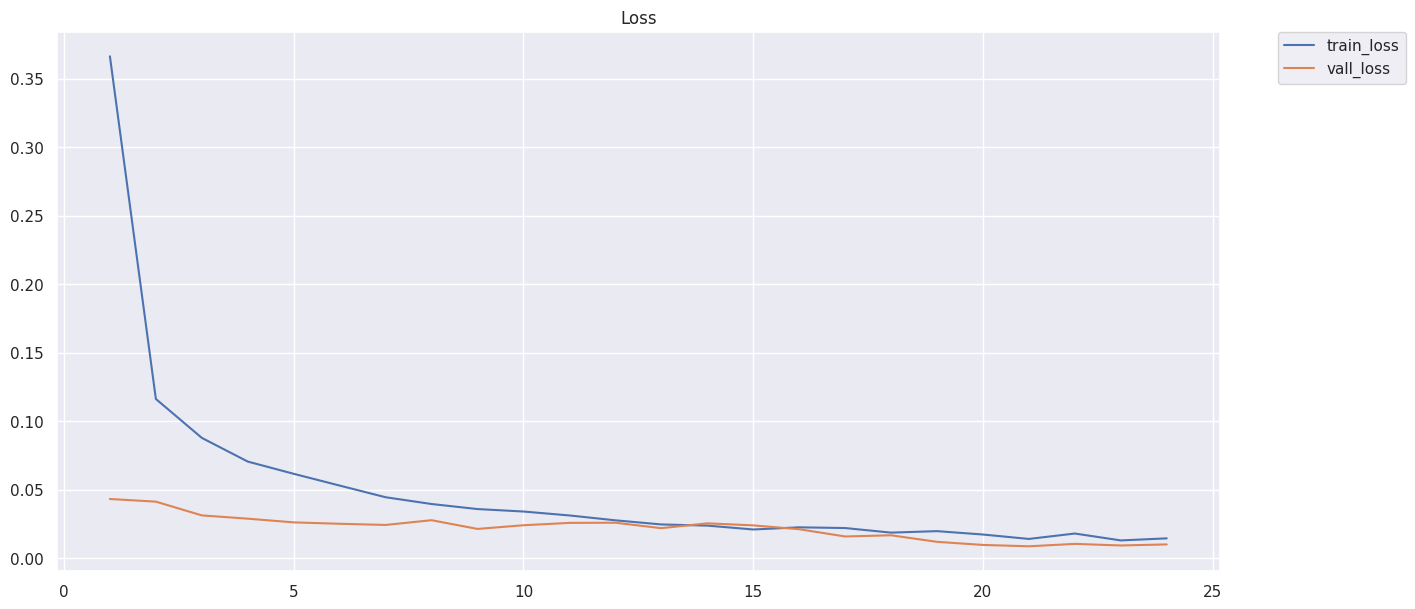

In [83]:
plt.figure(figsize=(15, 7))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

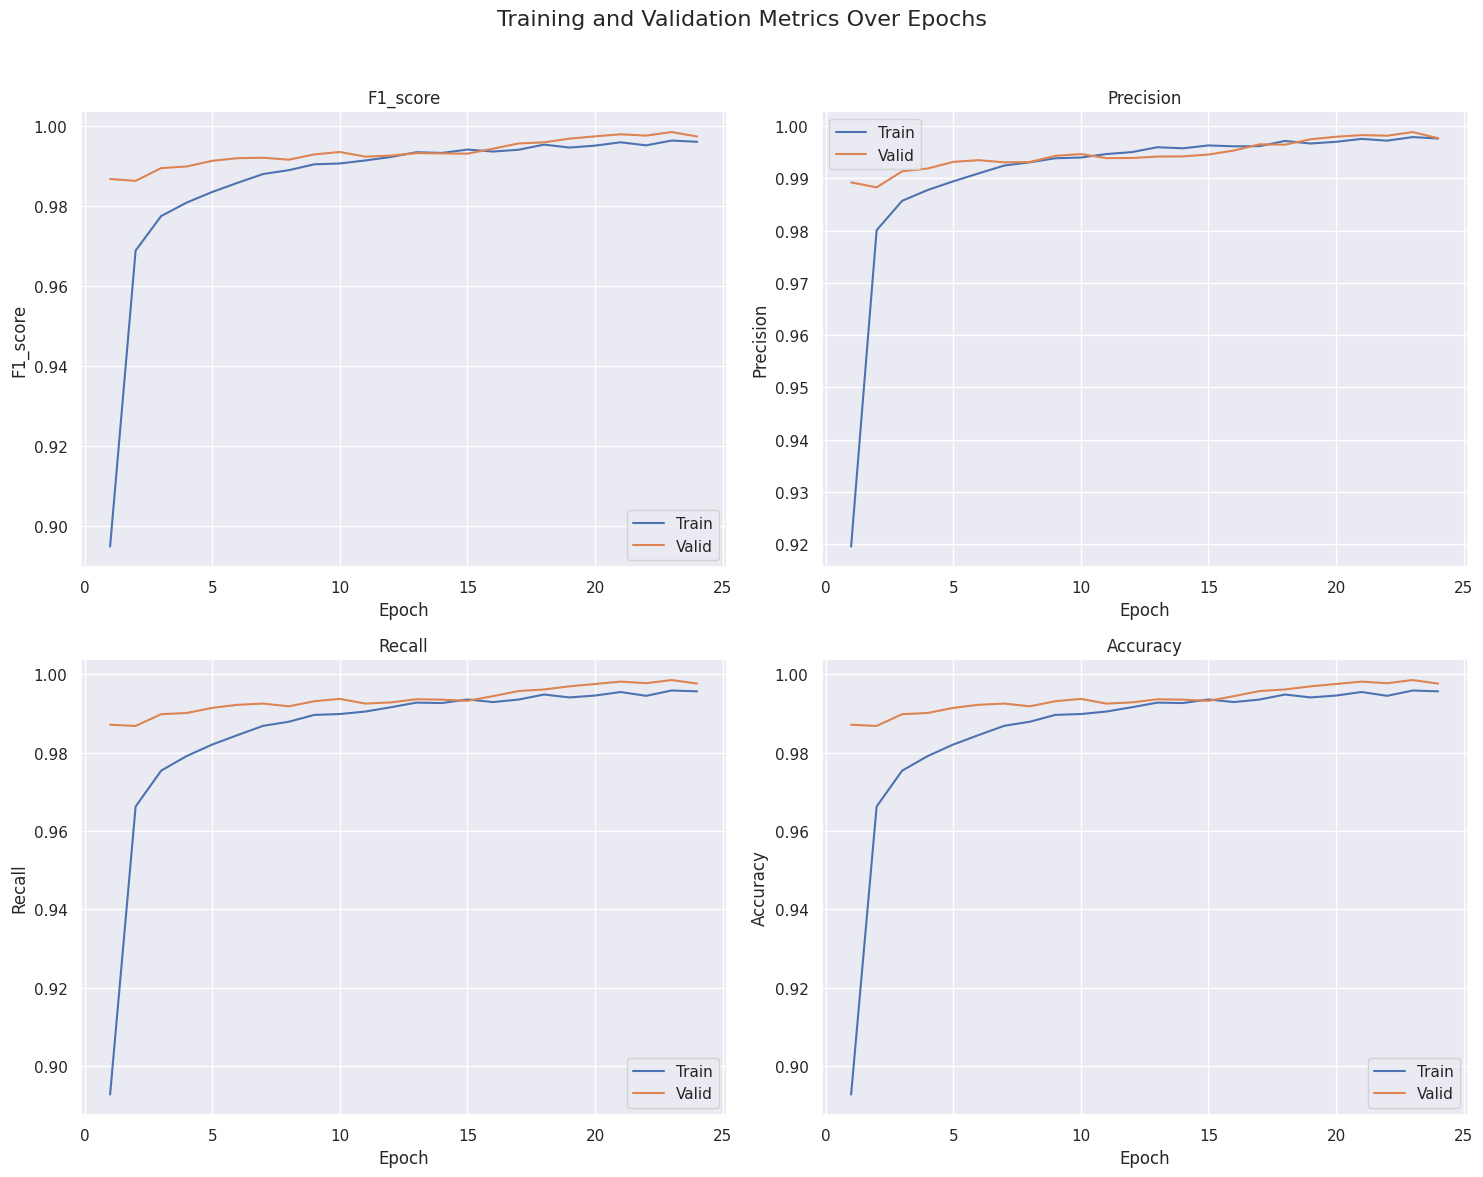

In [84]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [85]:
sub['Label'] = predict(test_dataloader, device, model)
sub.to_csv('model_torch_Additional_training.csv', index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
